In [1]:
import os, glob
from pathlib import Path
from tqdm.notebook import tqdm
tqdm.pandas()

from itertools import accumulate
from collections import Counter

import numpy as np
import pandas as pd

from tools.faster_rcnn import *

import matplotlib.pyplot as plt
%matplotlib inline

from tools.utils import *

import plotly.graph_objects as go

import dash
from dash import dcc
from dash import html

# OKVQA - Investigating Knowledge Graph

This notebook examines the ConceptNet Knowledge Graph. First, the extracted data is loaded.

In [2]:
# path to okvqa dataset (from text-investigation)
filename = 'OKVQA_conceptnet.json'
data_path = Path(os.getcwd()) / 'data'

okvqa = {}
okvqa['conceptnet'] = pd.read_json(data_path/filename)

In [3]:
okvqa['conceptnet'].head()

,start_label,relation,end_label,surfaceText,weight,dataset,language,query_word,from_question,from_image
0,is,HasContext,computing,None,2.0,/d/wiktionary/en,en,is,True,False
1,ye olde,RelatedTo,the,None,1.0,/d/wiktionary/en,en,the,True,False
2,hairstyle,Synonym,hairdo,[[hairstyle]] is a synonym of [[hairdo]],2.0,/d/wordnet/3.1,en,hairstyle,True,False
3,bingle,RelatedTo,hairstyle,None,1.0,/d/wiktionary/en,en,hairstyle,True,False
4,beehive,RelatedTo,hairstyle,None,1.0,/d/wiktionary/en,en,hairstyle,True,False


In [4]:
assert all(okvqa['conceptnet'].language == 'en')

So it is evident that some query words are associated to multiple relations. Let's see how many unique start_labels and end_labels, the data consists of, as well as the number of unique relations.

In [5]:
print("Number of unique start labels: {:d}".format(okvqa['conceptnet'].start_label.unique().__len__()))
print("Number of unique end labels: {:d}".format(okvqa['conceptnet'].end_label.unique().__len__()))

print("\nNumber of unique relations: {:d}".format(okvqa['conceptnet'].relation.unique().__len__()))

Number of unique start labels: 18786
Number of unique end labels: 14244

Number of unique relations: 40


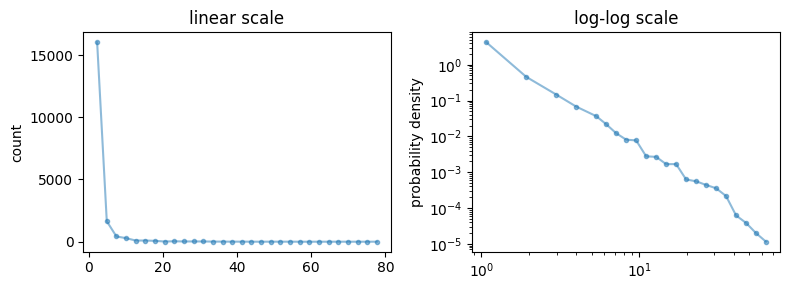

In [42]:
start_sorted, freq = list(zip(*sorted(Counter(okvqa['conceptnet'].start_label).items(), key=lambda x: x[1], reverse=True)))
LogAndLinearHist(pd.Series(freq))

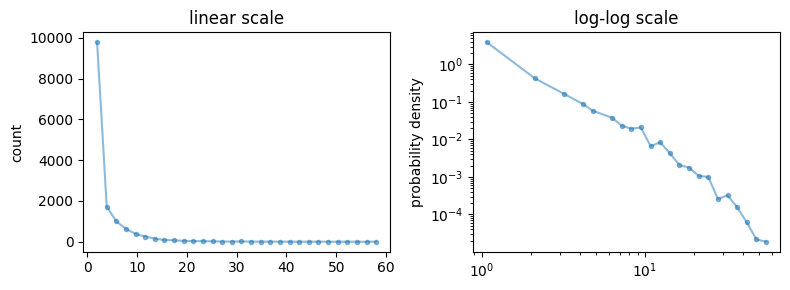

In [43]:
end_sorted, freq = list(zip(*sorted(Counter(okvqa['conceptnet'].end_label).items(), key=lambda x: x[1], reverse=True)))
LogAndLinearHist(pd.Series(freq))

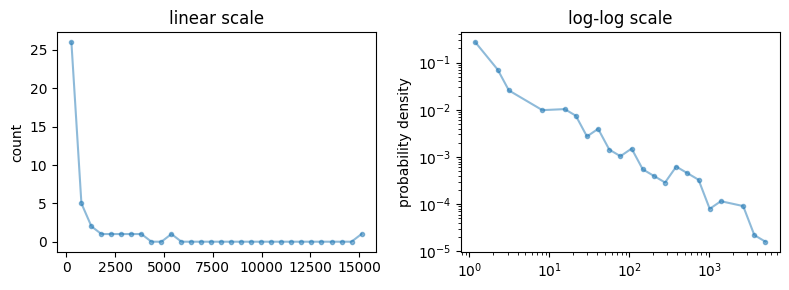

In [45]:
rel_sorted, freq = list(zip(*sorted(Counter(okvqa['conceptnet'].relation).items(), key=lambda x: x[1], reverse=True)))
LogAndLinearHist(pd.Series(freq))

In [81]:
import plotly.express as px

In [87]:
temp = pd.DataFrame(Counter(okvqa['conceptnet'].relation).most_common(), columns=['relation', 'freq'])
fig = px.pie(temp, values=temp.freq, names=temp.relation)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

In [88]:
okvqa['conceptnet'][okvqa['conceptnet'].relation == 'RelatedTo'].sample(20)

,start_label,relation,end_label,surfaceText,weight,dataset,language,query_word,from_question,from_image
26036,colony,RelatedTo,early,[[colony]] is related to [[early]],2.007984,/d/verbosity,en,early,True,False
29673,uncredited,RelatedTo,credits,None,1.000000,/d/wiktionary/en,en,credits,True,False
35275,table,RelatedTo,kitchens,[[table]] is related to [[kitchens]],0.323000,/d/verbosity,en,kitchens,True,False
4353,finish,RelatedTo,done,[[finish]] is related to [[done]],1.355000,/d/verbosity,en,done,True,False
41769,w,RelatedTo,w o,None,2.000000,/d/wiktionary/en,en,w,True,False
32634,month,RelatedTo,year,[[month]] is related to [[year]],6.264184,/d/verbosity,en,month,True,False
41677,huddled,RelatedTo,crowded,None,1.000000,/d/wiktionary/en,en,huddled,True,False
20372,ocean,RelatedTo,water,[[ocean]] is related to [[water]],5.871627,/d/verbosity,en,ocean,True,False
7667,crowd,RelatedTo,spaces,[[crowd]] is related to [[spaces]],0.206000,/d/verbosity,en,spaces,True,False
41962,cans,RelatedTo,can,None,1.000000,/d/wiktionary/fr,en,cans,True,False


In [36]:
from pprint import pprint

Counter(okvqa['conceptnet'].dataset).most_common()

[('/d/conceptnet/4/en', 11052),
 ('/d/wordnet/3.1', 11014),
 ('/d/wiktionary/en', 9541),
 ('/d/verbosity', 8512),
 ('/d/wiktionary/fr', 1558),
 ('/d/wiktionary/de', 1012),
 ('/d/opencyc', 265),
 ('/d/dbpedia/en', 55)]

Even though we asserted that the language of all extracted relations is English, we want to make sure when seeing the above structure of dataset sources, since it contains both the french (fr) and german (de) wiktionary. Luckily, when looking at these indeces, the relations are still in English - which means that they are just extracted from the Wiktionary of a foreign language.

In [11]:
okvqa['conceptnet'][okvqa['conceptnet'].dataset == '/d/wiktionary/fr'].sample(20)

,start_label,relation,end_label,surfaceText,weight,dataset,language,query_word,from_question,from_image
40625,deejay,FormOf,dj,None,1.0,/d/wiktionary/fr,en,dj,True,False
16357,rails,RelatedTo,rail,None,1.0,/d/wiktionary/fr,en,rails,True,False
31539,representing,RelatedTo,represent,None,1.0,/d/wiktionary/fr,en,representing,True,False
29422,respondent,RelatedTo,responder,None,1.0,/d/wiktionary/fr,en,responder,True,False
41421,goers,RelatedTo,goer,None,1.0,/d/wiktionary/fr,en,goers,True,False
15292,clocks,RelatedTo,clock,None,1.0,/d/wiktionary/fr,en,clocks,True,False
36401,attacks,RelatedTo,attack,None,1.0,/d/wiktionary/fr,en,attacks,True,False
25985,rode,RelatedTo,ride,None,1.0,/d/wiktionary/fr,en,rode,True,False
5894,he’d,RelatedTo,had,None,1.0,/d/wiktionary/fr,en,had,True,False
34478,occurred,RelatedTo,occur,None,1.0,/d/wiktionary/fr,en,occurred,True,False


In [12]:
okvqa['conceptnet'][okvqa['conceptnet'].dataset == '/d/wiktionary/de'].sample(20)

,start_label,relation,end_label,surfaceText,weight,dataset,language,query_word,from_question,from_image
32655,wary,Synonym,cautious,None,2.0,/d/wiktionary/de,en,wary,True,False
10158,dwellings,FormOf,dwelling,None,1.0,/d/wiktionary/de,en,dwellings,True,False
22532,protects,FormOf,protect,None,1.0,/d/wiktionary/de,en,protects,True,False
22913,remain,Synonym,stay,None,2.0,/d/wiktionary/de,en,remain,True,False
38942,eg,RelatedTo,grin,None,1.0,/d/wiktionary/de,en,eg,True,False
1236,does,FormOf,doe,None,1.0,/d/wiktionary/de,en,does,True,False
24856,drivers,FormOf,driver,None,1.0,/d/wiktionary/de,en,drivers,True,False
40046,drew,FormOf,draw,None,1.0,/d/wiktionary/de,en,drew,True,False
39067,professions,FormOf,profession,None,1.0,/d/wiktionary/de,en,professions,True,False
37908,sparrows,FormOf,sparrow,None,1.0,/d/wiktionary/de,en,sparrows,True,False


In [24]:
print("Number of extracted relations from questions: {:d}".format(okvqa['conceptnet'].from_question.sum()))
print("Number of extracted relations from questions: {:d}".format(okvqa['conceptnet'].from_image.sum()))

overlap = okvqa['conceptnet'][np.logical_and(okvqa['conceptnet']['from_question'] == True, okvqa['conceptnet']['from_image'] == True)]

print("\nRelations occurring in both question and images: {:d}".format(overlap.__len__()))

Number of extracted relations from questions: 42438
Number of extracted relations from questions: 807

Relations occurring in both question and images: 236


In [31]:
print("Total number of relations extracted: {:d}".format(42438 + 807 - 236))

Total number of relations extracted: 43009


In [25]:
overlap

,start_label,relation,end_label,surfaceText,weight,dataset,language,query_word,from_question,from_image
592,dog,CapableOf,bark,[[dog]] can [[bark]],16.0,/d/conceptnet/4/en,en,dog,True,True
602,a dog,IsA,pet,[[a dog]] is a type of [[pet]],6.0,/d/conceptnet/4/en,en,dog,True,True
603,a dog,CapableOf,run,An activity [[a dog]] can do is [[run]],6.0,/d/conceptnet/4/en,en,dog,True,True
712,a person,Desires,clothing,[[a person]] wants [[clothing]],6.0,/d/conceptnet/4/en,en,person,True,True
713,A slave,IsA,a person,[[A slave]] is [[a person]],6.0,/d/conceptnet/4/en,en,person,True,True
...,...,...,...,...,...,...,...,...,...,...
23114,purse,Synonym,handbag,None,2.0,/d/wiktionary/en,en,handbag,True,True
23115,a handbag,UsedFor,carry makeup,You can use [[a handbag]] to [[carry makeup]],2.0,/d/conceptnet/4/en,en,handbag,True,True
23116,a handbag,UsedFor,carry money,You can use [[a handbag]] to [[carry money]],2.0,/d/conceptnet/4/en,en,handbag,True,True
23117,handbag,Synonym,purse,None,2.0,/d/wiktionary/en,en,handbag,True,True


In [13]:
# overlapping relations (images and questions)
okvqa['conceptnet'][np.logical_and(okvqa['conceptnet']['from_question'] == True, okvqa['conceptnet']['from_image'] == True)]

,start_label,relation,end_label,surfaceText,weight,dataset,language,query_word,from_question,from_image
592,dog,CapableOf,bark,[[dog]] can [[bark]],16.0,/d/conceptnet/4/en,en,dog,True,True
602,a dog,IsA,pet,[[a dog]] is a type of [[pet]],6.0,/d/conceptnet/4/en,en,dog,True,True
603,a dog,CapableOf,run,An activity [[a dog]] can do is [[run]],6.0,/d/conceptnet/4/en,en,dog,True,True
712,a person,Desires,clothing,[[a person]] wants [[clothing]],6.0,/d/conceptnet/4/en,en,person,True,True
713,A slave,IsA,a person,[[A slave]] is [[a person]],6.0,/d/conceptnet/4/en,en,person,True,True
...,...,...,...,...,...,...,...,...,...,...
23114,purse,Synonym,handbag,None,2.0,/d/wiktionary/en,en,handbag,True,True
23115,a handbag,UsedFor,carry makeup,You can use [[a handbag]] to [[carry makeup]],2.0,/d/conceptnet/4/en,en,handbag,True,True
23116,a handbag,UsedFor,carry money,You can use [[a handbag]] to [[carry money]],2.0,/d/conceptnet/4/en,en,handbag,True,True
23117,handbag,Synonym,purse,None,2.0,/d/wiktionary/en,en,handbag,True,True


In [ ]:
okvqa['conceptnet'].weight.plot(kind='hist', bins=51, width=0.3)
plt.show()

In [130]:
okvqa['conceptnet'].iloc[okvqa['conceptnet'].weight.argmax()]

start_label                         baseball
relation                                 IsA
end_label                            a sport
surfaceText      [[baseball]] is [[a sport]]
weight                             22.891046
dataset                   /d/conceptnet/4/en
language                                  en
query_word                             sport
from_question                           True
from_image                             False
Name: 2077, dtype: object

In [131]:
okvqa['conceptnet'].iloc[okvqa['conceptnet'].weight.argmin()]

start_label                                      letter
relation                                      RelatedTo
end_label                                     keyboards
surfaceText      [[letter]] is related to [[keyboards]]
weight                                              0.1
dataset                                    /d/verbosity
language                                             en
query_word                                    keyboards
from_question                                      True
from_image                                        False
Name: 17398, dtype: object

## Investigating ConceptNet Numberbatch for OKVQA text

## Investigating ConceptNet downloaded through MMF

In [ ]:
# path to okvqa dataset (from text-investigation)
vocab_file = 'graph_vocab_cn.pth.tar'
conceptnet_file = 'cn_graph.pth.tar'
data_path = Path(os.getcwd()) / 'data/mmf/conceptnet'

graph_vocab = torch.load(data_path/vocab_file)
conceptNet = torch.load(data_path/conceptnet_file)

In [ ]:
conceptNet.keys()

In [ ]:
conceptNet['concepts'].__len__()

In [ ]:
np.shape(conceptNet['triplets'])

In [ ]:
graph_vocab.__len__()

In [ ]:
for i in range(conceptNet['triplets'].__len__()):
    concept1, relation, concept2 = conceptNet['triplets'][i]

    print(f"{conceptNet['concepts'][concept1]} - {conceptNet['relations'][relation]} - {conceptNet['concepts'][concept2]}")